### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 3: Predicción de una serie de tiempo caótica

En esta tarea se pide entrenar y evaluar un predictor para el sistema no-lineal [Mackey-Glass](https://en.wikipedia.org/wiki/Mackey-Glass_equations)

Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = \beta \frac{ y(t-\tau)}{1 + y(t-\tau)^{n}} - \gamma y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

En esta tarea nos limitaremos en estudiar el caso con $n=10$, $\gamma = 0.1$ y $\beta = 0.2$

El valor del parámetro $\tau$ modifica el comportamiento dinámico del sistema, en particular se tiene que

- $\tau = 17$ el sistema tiene un comportamiento debilmente caótico
- $\tau = 30$ el sistema tiene un comportamiento fuertemente caótico

La ecuación de diferencial anterior fue propuesta por Michael Mackey and Leon Glass en 1977 como modelo para procesos fisiológicos asociados a la [homeostasis](https://es.wikipedia.org/wiki/Homeostasis)

El código adjunto a esta tarea genera la serie de tiempo en función 

Se generan 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar, los siguientes 250 puntos para calibrar los hiperparámetros y los últimos 250 para evaluar y comparar los filtros

Loading BokehJS ...

<IPython.core.display.Javascript object>


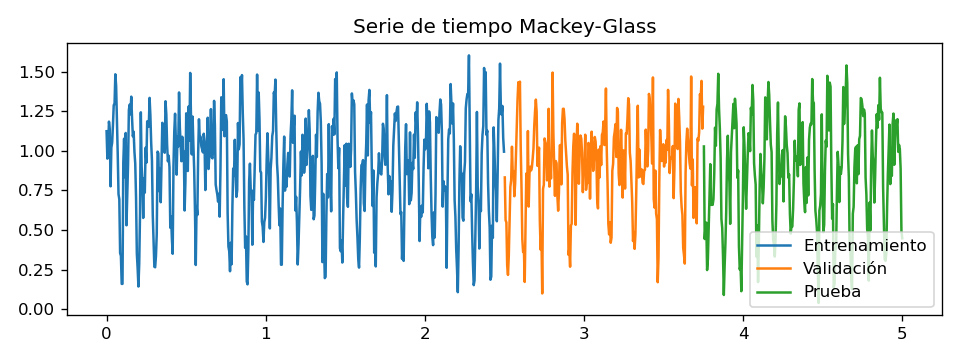

In [8]:
from IPython.display import YouTubeVideo, HTML, Audio
from bokeh.layouts import column, row
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import Figure, show, output_notebook
output_notebook()

import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
from mackey import MackeyGlass

# Puede calcular el error medio cuadrático normalizado usando:
NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

# Gráfico
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=30.)
fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
ax.plot(t_train, y_train, label='Entrenamiento')
ax.plot(t_valid, y_valid, label='Validación')
ax.plot(t_test, y_test, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();


## (45%) Predicción con algoritmo LMS

1. Describa en detalle el algoritmo LMS e implemente un predictor a un paso basado en el **algoritmo LMS normalizado**
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\mu$ y $L$ que minimiza el NMSE en el conjunto de validación. Se recomienda realizar un barrido logarítmo para $\mu$. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo ($\tau=17$ y $\tau=30$). Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

LMS se usa en filtros adaptativos, sirve para encontrar los coeficientes del filtro permitiendo obtener el valor esperado mínimo del cuadrado de la señal de error, definida como la diferencia entre la señal deseada y la señal producida a la salida del filtro.

Este filtro se adapta en base al error en el instante actual únicamente. No requiere medidas de las funciones de correlación, ni tampoco inversión de la matriz de correlación.

El algoritmo LMS es un algoritmo de filtrado lineal adaptativo que, en general, consiste de dos procesos básicos:
- Un proceso de filtrado, que involucra:
    El cómputo de la salida de un filtro lineal en respuesta a una señal de entrada, y la generación de una estimación del error mediante la comparación de esta salida con la señal deseada.
- Un proceso adaptativo, que involucra:
    El ajuste automático de los parámetros del filtro de acuerdo al error estimado.

A diferencia del filtro de Wiener no se requiere conocimiento estadístico del proceso, tampoco se requiere calcular e invertir la matriz de correlación y, se entrena de manera recursiva y online.


<IPython.core.display.Javascript object>


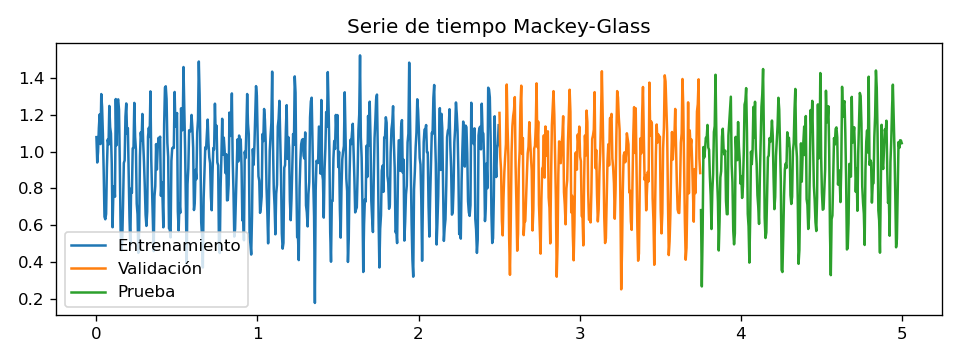

In [60]:
# Gráfico 1
(t_train1, y_train1), (t_valid1, y_valid1), (t_test1, y_test1) = MackeyGlass(tau=17.)
fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
ax.plot(t_train1, y_train1, label='Entrenamiento')
ax.plot(t_valid1, y_valid1, label='Validación')
ax.plot(t_test1, y_test1, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();

In [61]:
class Filtro_NLMS:
    
    def __init__(self, L, mu, delta=1e-6, winit=None):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.mu = mu
        self.delta = delta
        
    def update(self, un, dn):
        # Asumiendo que un = [u[n], u[n-1], ..., u[n-L]]
        unorm = np.dot(un, un) + self.delta
        yn = np.dot(self.w, un)
        self.w += 2*self.mu*(dn - yn)*(un/unorm)
        return yn

In [64]:
import cmath
import math
L1= 5
mu1 = 0.1
#a1 sera el error medio cuadratico 
a1=0.0

mu_final1,L_final1= 0.0,0.0
for i in range(30):
    for j in range(30):    
        NLMS_valid1 = Filtro_NLMS(L1,mu1);
        matriz_valid1 = np.zeros(shape=(len(t_valid1), len(y_valid1)));

        for k in range(L1+1, len(t_valid1)):
            matriz_valid1[k, 1] = NLMS_valid1.update(y_valid1[k-L1-1:k][::-1], y_valid1[k]);

        # Calculamos el error medio cuadrático normalizado usando:

        a1=NMSE(y_valid1,matriz_valid1)
        if (NMSE(y_valid1,matriz_valid1)<=a1):
            a_final1=NMSE(y_valid1,matriz_valid1)
            mu_final1=mu1
            L_final1=L1

        mu1 = mu1 +0.01;
    L1=L1+1;
    mu1=0.1;
print("mu: ",mu_final1)
print("L: ",L_final1)
print("a: ",a_final1)

mu:  0.39000000000000024
L:  34
a:  876366.5380295363


Usando el error medio cuadratico encontramos los valores nu y L son mu=0.39 y L=34

En el conjunto de validacion.

In [65]:
L1 = 34
mu1 = 0.39
  
NLMS_valid1 = Filtro_NLMS(L1,mu1);
matriz_valid1 = np.zeros(shape=(len(t_valid1), len(y_valid1)));
    
for k in range(L1+1, len(t_valid1)):
    matriz_valid1[k, 1] = NLMS_valid1.update(y_valid1[k-L1-1:k][::-1], y_valid1[k]);
        
p1 = Figure(plot_width=800, plot_height=300)
p1.line(t_valid1, y_valid1)
p1.line(t_valid1, matriz_valid1[:, 1], color='red')
show(p1)
        


Ahora con tau 30

<IPython.core.display.Javascript object>


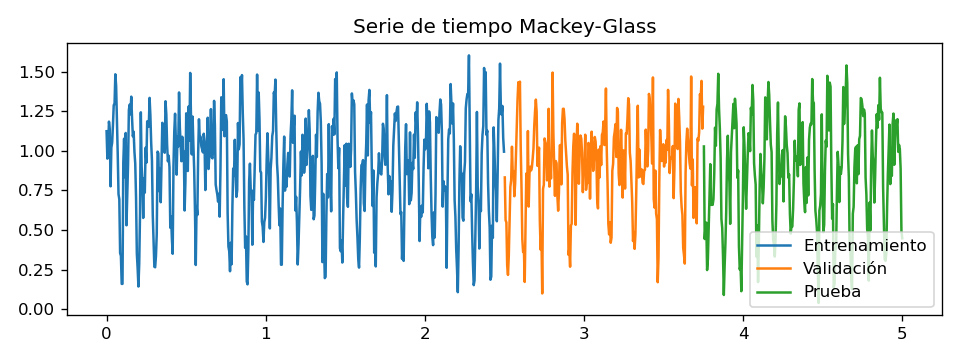

In [70]:
# Gráfico 2
(t_train2, y_train2), (t_valid2, y_valid2), (t_test2, y_test2) = MackeyGlass(tau=30.)
fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
ax.plot(t_train2, y_train2, label='Entrenamiento')
ax.plot(t_valid2, y_valid2, label='Validación')
ax.plot(t_test2, y_test2, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();

In [78]:
L2= 5
mu2 = 0.1
#a2 sera el error medio cuadratico 
a2=0.0

mu_final2,L_final2= 0.0,0.0
for i in range(30):
    for j in range(30):    
        NLMS_valid2 = Filtro_NLMS(L2,mu2);
        matriz_valid2 = np.zeros(shape=(len(t_valid2), len(y_valid2)));

        for k in range(L2+1, len(t_valid2)):
            matriz_valid2[k, 1] = NLMS_valid2.update(y_valid2[k-L2-1:k][::-1], y_valid2[k]);

        # Calculamos el error medio cuadrático normalizado usando:

        a2=NMSE(y_valid2,matriz_valid2)
        if (NMSE(y_valid2,matriz_valid2)<=a2):
            a_final2=NMSE(y_valid2,matriz_valid2)
            mu_final2=mu2
            L_final2=L2

        mu2 = mu2 +0.01;
    L2=L2+1;
    mu2=0.1;
print("mu: ",mu_final2)
print("L: ",L_final2)
print("a: ",a_final2)

mu:  0.39000000000000024
L:  34
a:  718987.774023489


In [79]:
L2 = 34
mu2 = 0.39
  
NLMS_valid2 = Filtro_NLMS(L2,mu2);
matriz_valid2 = np.zeros(shape=(len(t_valid2), len(y_valid2)));
    
for k in range(L2+1, len(t_valid2)):
    matriz_valid2[k, 1] = NLMS_valid2.update(y_valid2[k-L2-1:k][::-1], y_valid2[k]);
        
p1 = Figure(plot_width=800, plot_height=300)
p1.line(t_valid2, y_valid2)
p1.line(t_valid2, matriz_valid2[:, 1], color='red')
show(p1)

In [83]:
p1 = Figure(plot_width=800, plot_height=250)
p1.line(t_valid1, y_valid2)
p1.line(t_valid1, matriz_valid1[:, 1], color='red')
show(p1);
p2 = Figure(plot_width=800, plot_height=250)
p2.line(t_valid2, y_valid2)
p2.line(t_valid2, matriz_valid2[:, 1], color='red')
show(p2);

## (45%) Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS e implemente un predictor a un paso basado en el algoritmo RLS. Resalte las diferencias con el algoritmo LMS
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\beta$ y $L$ que minimiza el NMSE en el conjunto de validación. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo. Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

## (10%) Comparación entre LMS y RLS

1. Compare el mejor predictor LMS y RLS en el conjunto de test en términos de la calidad de la predicción y la velocidad a la que sigue los cambios. Comente y discuta
